In [23]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import geopandas as gpd
import pandas as pd
import sklearn

In [2]:
%store -r cook_county_gdf_semiannual
%store -r CC_nodeaths
cook_county_gdf = cook_county_gdf_semiannual

In [3]:
#add in missing 58 tracts

cook_county_gdf['semiannual'].fillna(9999, inplace=True) 
cook_county_gdf['year'].fillna(9999, inplace=True)

In [4]:
cook_county_gdf.loc[cook_county_gdf['year'] == 9999, 'GEOID'].nunique() #should be 58

56

In [5]:
columns_to_keep = ['STATEFP', 'COUNTYFP', 'TRACTCE','NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'geometry']

gdf_semi = cook_county_gdf.groupby(['GEOID', 'semiannual', 'year']).agg({'deaths': 'sum', **{col: 'first' for col in columns_to_keep}}).reset_index()

In [6]:

gdf_semi.head()

,GEOID,semiannual,year,deaths,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,17031010100,1,2016.0,2,17,031,010100,101,Census Tract 101,G5020,S,379511,0,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022..."
1,17031010100,1,2017.0,1,17,031,010100,101,Census Tract 101,G5020,S,379511,0,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022..."
2,17031010100,1,2019.0,1,17,031,010100,101,Census Tract 101,G5020,S,379511,0,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022..."
3,17031010100,1,2020.0,2,17,031,010100,101,Census Tract 101,G5020,S,379511,0,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022..."
4,17031010100,1,2022.0,1,17,031,010100,101,Census Tract 101,G5020,S,379511,0,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022..."


### Making DF square - one "semi-annual" period for each tract

In [7]:
gdf_semi.loc[gdf_semi['year'] == 9999, 'deaths'] = 0
gdf_semi.loc[gdf_semi['semiannual'] == 9999, 'deaths'] = 0

# Replace 9999 with 2015 in the 'year' column
gdf_semi['year'].replace(9999, 2015, inplace=True)
gdf_semi['semiannual'].replace(9999, 1, inplace=True)

In [8]:
gdf_semi['GEOID'].nunique()  #should be 1332

1332

In [9]:
##nested for loops
years = range(2015, 2024)
periods = [1, 2]

existing_combinations = set(zip(gdf_semi['GEOID'], gdf_semi['year'], gdf_semi['semiannual']))
updated_rows = []

for tract in gdf_semi['GEOID'].unique():
    for year in years:
        for period in periods:
            combination = (tract, year, period)
            if combination not in existing_combinations:
                new_row = {'GEOID': tract, 'year': year, 'semiannual': period, 'deaths': 0}
                updated_rows.append(new_row)

gdf_semi = pd.concat([gdf_semi, pd.DataFrame(updated_rows)], ignore_index=True)

In [10]:
#fills in NAs produced from above
unique_tracts = gdf_semi['GEOID'].unique()

for tract in unique_tracts:
    tract_rows = gdf_semi[gdf_semi['GEOID'] == tract]
    non_na_row = tract_rows.dropna().iloc[0]  # Get the first row without any NAs
    
    for column in columns_to_keep:
        gdf_semi.loc[(gdf_semi['GEOID'] == tract) & gdf_semi[column].isna(), column] = non_na_row[column]

In [11]:
gdf_semi = gdf_semi[gdf_semi['year'] != 2014] #take out 2014 b/c data starts AUGUST 2014, not full year

In [12]:
gdf_semi.shape #should be (26640, 15)


(23976, 16)

In [13]:
#confirms all years and periods present
years = range(2015, 2024)  
periods = [1, 2]  

for tract in gdf_semi['GEOID'].unique():
    for year in years:
        for period in periods:
            if not ((gdf_semi['GEOID'] == tract) & (gdf_semi['year'] == year) & (gdf_semi['semiannual'] == period)).any():
                print("Missing row for GEOID {} in year {} semiannual {}".format(tract, year, period))


In [14]:
#Any NAs in data frame?

has_na = gdf_semi.isna().any().any()

if has_na:
    print("There are missing values in the dataframe.")
else:
    print("There are no missing values in the dataframe.")


There are no missing values in the dataframe.


In [15]:
#Any Duplicates?
has_duplicates = gdf_semi.duplicated().any()

if has_duplicates:
    print("There are duplicate rows in the dataframe.")
else:
    print("There are no duplicate rows in the dataframe.")


There are no duplicate rows in the dataframe.


In [16]:
#change format of year and quarters

gdf_semi['year'] = pd.to_datetime(gdf_semi['year'].astype(int).astype(str), format='%Y').dt.year
gdf_semi['semiannual'] = gdf_semi['semiannual'].astype(str).replace('1.0', '1').replace('2.0', '2')


In [17]:
gdf_semi.columns = ['GEOID', 'semiannual', 'year', 'deaths', 'STATEFP', 'COUNTYFP',
       'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'lat', 'lon', 'geometry']

In [18]:
#timestep column
gdf_semi = gdf_semi.sort_values(by=['GEOID', 'year', 'semiannual'])
gdf_semi['timestep'] = gdf_semi.groupby(['GEOID']).cumcount() + 1

#season column
gdf_semi = gdf_semi.sort_values(by=['GEOID', 'year', 'semiannual'])

def map_season(semiannual):
    return 'jan-jun' if semiannual == '1' else 'jul-dec'

gdf_semi['season'] = gdf_semi['semiannual'].map(map_season)

### store gdf


In [24]:
gdf_semi = gpd.GeoDataFrame(gdf_semi, geometry='geometry')

In [25]:
gdf_semi = gdf_semi[gdf_semi['year'] != 2023]
gdf_semi = gdf_semi[gdf_semi['year'] != 2014]
%store gdf_semi

Stored 'gdf_semi' (GeoDataFrame)


<Axes: >

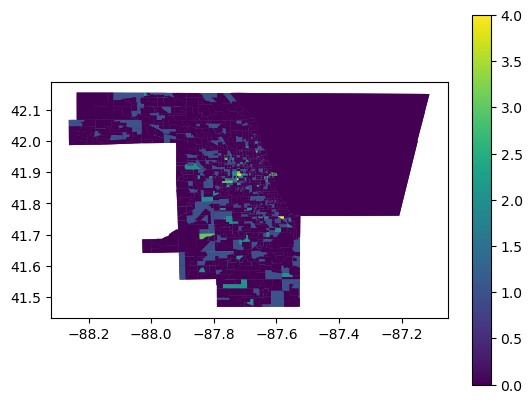

In [26]:
gdf_semi[gdf_semi['year']==2015].plot('deaths', legend=True)


In [21]:
gdf_semi

,GEOID,semiannual,year,deaths,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,lat,lon,geometry,timestep,season
7441,17031010100,1,2015,0,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022...",1,jan-jun
7,17031010100,2,2015,1,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022...",2,jul-dec
0,17031010100,1,2016,2,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022...",3,jan-jun
8,17031010100,2,2016,1,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022...",4,jul-dec
1,17031010100,1,2017,1,17,031,010100,101,Census Tract 101,G5020,S,379511.0,0.000000e+00,+42.0212553,-087.6698301,"POLYGON ((-87.67720 42.02294, -87.67628 42.022...",5,jan-jun
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24155,17031990000,2,2020,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.74156 42.15323, -87.72176 42.153...",12,jul-dec
24156,17031990000,1,2021,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.74156 42.15323, -87.72176 42.153...",13,jan-jun
24157,17031990000,2,2021,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.74156 42.15323, -87.72176 42.153...",14,jul-dec
24158,17031990000,1,2022,0,17,031,990000,9900,Census Tract 9900,G5020,S,0.0,1.717072e+09,+41.9739391,-087.4002947,"POLYGON ((-87.74156 42.15323, -87.72176 42.153...",15,jan-jun
